In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

CIFAR-10 Dataset: 171MB [00:27, 6.28MB/s]                              


All files found!



Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


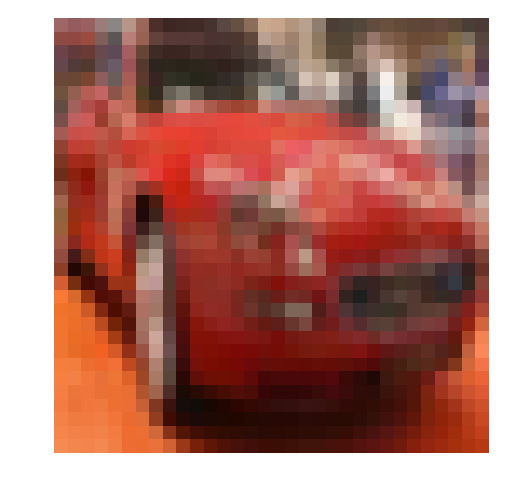

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [3]:
import numpy as np
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    return x/255
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


In [4]:
map = np.eye(10)

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    return np.vstack([map[_,:] for _ in x])

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, shape=(None, *image_shape), name='x')

def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, shape=(None, n_classes), name='y')

def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, name='keep_prob')

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


In [8]:
MEAN_INIT = 0.001
STDDEV_INIT = 0.05

def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernel size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    :return: A tensor that represents convolution and max pooling of x_tensor
    """
    x_batch, x_height, x_width, x_depth = x_tensor.shape
    filter_weights = tf.Variable(tf.truncated_normal(mean=MEAN_INIT, stddev=STDDEV_INIT, shape=[*conv_ksize, x_depth.value, conv_num_outputs]))
    bias = tf.Variable(tf.truncated_normal(mean=MEAN_INIT, stddev=STDDEV_INIT, shape=[conv_num_outputs]))
    x_tensor = tf.nn.conv2d(x_tensor, filter_weights, strides=[1, *conv_strides, 1], padding='SAME')
    x_tensor = tf.nn.bias_add(x_tensor, bias)
    x_tensor = tf.nn.relu(x_tensor)
    x_tensor = tf.nn.max_pool(x_tensor, ksize=[1, *pool_ksize, 1], strides=[1, *pool_strides, 1], padding='SAME')
    return x_tensor

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

Tests Passed


In [9]:
from functools import reduce

def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    dim = reduce(lambda x, y: x*y, x_tensor.shape[1:])
    return tf.reshape(x_tensor, [-1, dim.value])


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)

Tests Passed


In [10]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weights = tf.Variable(tf.truncated_normal(mean=MEAN_INIT, stddev=STDDEV_INIT, shape=[x_tensor.shape[1].value, num_outputs]))
    bias = tf.Variable(tf.truncated_normal(mean=MEAN_INIT, stddev=STDDEV_INIT, shape=[num_outputs]))
    return tf.nn.relu(tf.add(tf.matmul(x_tensor, weights), bias))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)

Tests Passed


In [11]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weights = tf.Variable(tf.truncated_normal(mean=MEAN_INIT, stddev=STDDEV_INIT, shape=[x_tensor.shape[1].value, num_outputs]))
    bias = tf.Variable(tf.truncated_normal(mean=MEAN_INIT, stddev=STDDEV_INIT, shape=[num_outputs]))
    return tf.add(tf.matmul(x_tensor, weights), bias)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)

Tests Passed


In [12]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    x = conv2d_maxpool(x, 16, (5, 5), (1, 1), (2, 2), (2, 2))
    x = conv2d_maxpool(x, 32, (5, 5), (1, 1), (2, 2), (2, 2))
    x = conv2d_maxpool(x, 64, (5, 5), (1, 1), (2, 2), (2, 2))
    x = flatten(x)
    
    print("Final shape is: {}".format(x.shape[1]))
    x = fully_conn(x, num_outputs=786)
    x = fully_conn(x, num_outputs=786)
    x = tf.nn.dropout(x, keep_prob)
    x = output(x, num_outputs=10)
    
    return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Final shape is: 1024
Final shape is: 1024
Neural Network Built!


In [13]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    feed_dict = {'keep_prob:0': keep_probability, 'x:0': feature_batch, 'y:0': label_batch}
    session.run(optimizer, feed_dict=feed_dict)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


In [14]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    feed_cost = {'keep_prob:0': 1.0, 'x:0': feature_batch, 'y:0': label_batch}
    feed_valid = {'keep_prob:0': 1.0, 'x:0': valid_features, 'y:0': valid_labels}
    cost = session.run(cost, feed_dict=feed_cost)
    accuracy = session.run(accuracy, feed_dict=feed_valid)
    print("cost: {}, accuracy: {}".format(cost, accuracy))

In [16]:
epochs = 50
batch_size = 64
keep_probability = 0.8

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  cost: 2.009424924850464, accuracy: 0.3523999750614166
Epoch  2, CIFAR-10 Batch 1:  cost: 1.761795997619629, accuracy: 0.42979997396469116
Epoch  3, CIFAR-10 Batch 1:  cost: 1.5836334228515625, accuracy: 0.4753999710083008
Epoch  4, CIFAR-10 Batch 1:  cost: 1.4252293109893799, accuracy: 0.49299997091293335
Epoch  5, CIFAR-10 Batch 1:  cost: 1.1230236291885376, accuracy: 0.49039995670318604
Epoch  6, CIFAR-10 Batch 1:  cost: 0.8896859288215637, accuracy: 0.5227999091148376
Epoch  7, CIFAR-10 Batch 1:  cost: 0.8266783356666565, accuracy: 0.5077999234199524
Epoch  8, CIFAR-10 Batch 1:  cost: 0.6698145866394043, accuracy: 0.5137999653816223
Epoch  9, CIFAR-10 Batch 1:  cost: 0.5574707388877869, accuracy: 0.5017999410629272
Epoch 10, CIFAR-10 Batch 1:  cost: 0.3947780728340149, accuracy: 0.5161999464035034
Epoch 11, CIFAR-10 Batch 1:  cost: 0.3822922706604004, accuracy: 0.5357999801635742
Epoch 12, CIFAR-10 Batch 1:  cos

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  cost: 1.9518980979919434, accuracy: 0.33139997720718384
Epoch  1, CIFAR-10 Batch 2:  cost: 1.4194775819778442, accuracy: 0.44679999351501465
Epoch  1, CIFAR-10 Batch 3:  cost: 1.177060842514038, accuracy: 0.5121999979019165
Epoch  1, CIFAR-10 Batch 4:  cost: 1.2601944208145142, accuracy: 0.5085999369621277
Epoch  1, CIFAR-10 Batch 5:  cost: 1.1864583492279053, accuracy: 0.5679999589920044
Epoch  2, CIFAR-10 Batch 1:  cost: 1.4636508226394653, accuracy: 0.5755998492240906
Epoch  2, CIFAR-10 Batch 2:  cost: 1.0008339881896973, accuracy: 0.5797998905181885
Epoch  2, CIFAR-10 Batch 3:  cost: 0.7916618585586548, accuracy: 0.6027998924255371
Epoch  2, CIFAR-10 Batch 4:  cost: 0.8617904186248779, accuracy: 0.6187999248504639
Epoch  2, CIFAR-10 Batch 5:  cost: 0.9458162784576416, accuracy: 0.6245999336242676
Epoch  3, CIFAR-10 Batch 1:  cost: 0.9336293935775757, accuracy: 0.6315999031066895
Epoch  3, CIFAR-10 Batch 2:  cost: 0.7002675533294678, accuracy

Testing Accuracy: 0.6626194267515924



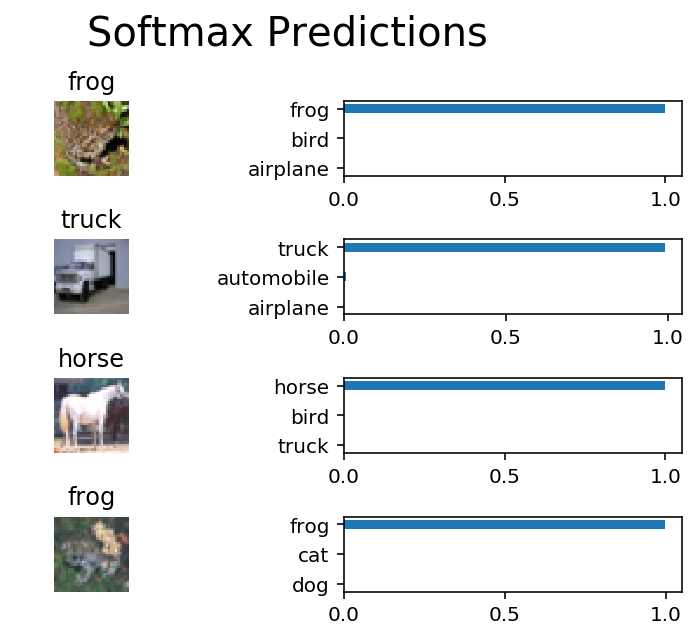

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()